In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_raw_jv(filepath):
    df = pd.read_csv(
        filepath,
        encoding="latin1",
        sep=None,
        engine="python"
    )
    df = df.apply(pd.to_numeric, errors="coerce")
    df = df.dropna(how="all")
    df = df.dropna(axis=1, how="all")
    return df

In [3]:
def standardize_V_J(df_raw):
    df2 = df_raw.iloc[:, :2].copy()
    df2.columns = ["Voltage_V", "Current density_mAcm-2"]
    df2 = df2.dropna()
    return df2

In [9]:
def extract_device_params(df_vj, pin_mw_cm2=100, npts=8):
    V = df_vj["Voltage_V"].to_numpy()
    J = df_vj["Current density_mAcm-2"].to_numpy()

    order = np.argsort(V)
    V = V[order]
    J = J[order]

    Jsc = np.interp(0.0, V, J)

    orderJ = np.argsort(J)
    Voc = np.interp(0.0, J[orderJ], V[orderJ])

    P = V * J
    i_mpp = np.argmax(P)
    Pmax = P[i_mpp]
    Vmp = V[i_mpp]
    Jmp = J[i_mpp]

    FF = Pmax / (Voc * Jsc) if (Voc != 0 and Jsc != 0) else np.nan
    PCE = (Pmax / pin_mw_cm2) * 100

    idx_v0 = np.argsort(np.abs(V - 0.0))[:npts]
    a_rsh, _ = np.polyfit(J[idx_v0], V[idx_v0], 1)
    Rsh = abs(a_rsh) * 1000

    idx_j0 = np.argsort(np.abs(J - 0.0))[:npts]
    a_rs, _ = np.polyfit(J[idx_j0], V[idx_j0], 1)
    Rs = abs(a_rs) * 1000

    return {
        "Voc_V": Voc,
        "Jsc_mAcm-2": Jsc,
        "FF": FF,
        "PCE_percent": PCE,
        "Rs_ohm_cm2": Rs,
        "Rsh_ohm_cm2": Rsh,
        "Vmp_V": Vmp,
        "Jmp_mAcm-2": Jmp,
        "Pmax_mWcm-2": Pmax
    }

In [10]:
raw_files = [
    "device2.csv",
    "device3.csv",
    "device 4.csv",
    "device5.csv",
]

In [11]:
os.makedirs("summary", exist_ok=True)

summary_rows = []

for f in raw_files:
    print("Processing:", f)

    df_raw = load_raw_jv(f)
    df_vj = standardize_V_J(df_raw)

    params = extract_device_params(df_vj)
    params["Device_ID"] = os.path.splitext(f)[0]

    summary_rows.append(params)

    pd.DataFrame([params]).to_csv(
        f"summary/{params['Device_ID']}_summary.csv",
        index=False
    )

summary_df = pd.DataFrame(summary_rows)
summary_df

Processing: device2.csv
Processing: device3.csv
Processing: device 4.csv
Processing: device5.csv


,Voc_V,Jsc_mAcm-2,FF,PCE_percent,Rs_ohm_cm2,Rsh_ohm_cm2,Vmp_V,Jmp_mAcm-2,Pmax_mWcm-2,Device_ID
0,1.107608,19.880957,0.552266,12.161059,6.997372,684.472186,0.76665,15.862595,12.161059,device2
1,1.159400,20.154208,0.760782,17.777031,5.103655,117.766491,0.94790,18.754120,17.777031,device3
2,1.107751,21.972702,0.788015,19.180519,3.857324,294.360696,0.94790,20.234750,19.180519,device 4
3,1.151629,20.737578,0.760430,18.160585,5.488169,7251.296569,0.96000,18.917276,18.160585,device5


In [12]:
df = summary_df.copy()

print("Number of devices:", len(df))
df

Number of devices: 4


,Voc_V,Jsc_mAcm-2,FF,PCE_percent,Rs_ohm_cm2,Rsh_ohm_cm2,Vmp_V,Jmp_mAcm-2,Pmax_mWcm-2,Device_ID
0,1.107608,19.880957,0.552266,12.161059,6.997372,684.472186,0.76665,15.862595,12.161059,device2
1,1.159400,20.154208,0.760782,17.777031,5.103655,117.766491,0.94790,18.754120,17.777031,device3
2,1.107751,21.972702,0.788015,19.180519,3.857324,294.360696,0.94790,20.234750,19.180519,device 4
3,1.151629,20.737578,0.760430,18.160585,5.488169,7251.296569,0.96000,18.917276,18.160585,device5


In [13]:
df.to_csv("perovskite_device_dataset_day3.csv", index=False)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df[["Voc_V", "Jsc_mAcm-2", "FF", "Rs_ohm_cm2", "Rsh_ohm_cm2"]]
y = df["PCE_percent"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²  :", r2_score(y_test, y_pred))

MAE : 2.54589089105127
RMSE: 2.54589089105127
R²  : nan


d:\Anaconda3\envs\perovAI\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Jsc_mAcm-2     1.047758
FF             0.121330
Voc_V          0.001349
Rsh_ohm_cm2    0.000410
Rs_ohm_cm2    -1.579341
dtype: float64


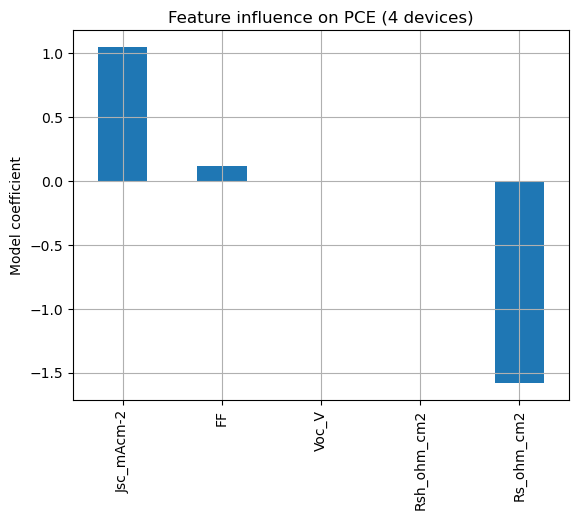

In [16]:
coefs = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
print(coefs)

coefs.plot(kind="bar")
plt.ylabel("Model coefficient")
plt.title("Feature influence on PCE (4 devices)")
plt.grid(True)
plt.show()
